# El acantilado
- Estudiante: Lenin G. Falconí
- Fecha: 2025-04-01
## Objetivo
- Revisar Q learning i.e. linea roja (ver diagrama)
- Revisar SARSA i.e. azul
## Condiciones
- Es una cuadricula con un punto de arranque S y un punto objetivo G
- Existe una serie de celdas que son el alcantilado. Devuelven $R=-100$
- El resto de la cuadricula da $R=-1$
- Acciones: 4 movimientos
- Restricciones para que no salga de la cuadricula
## Observaciones
- Incrementar el numero de observaciones

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# Dimensiones de la cuadricula
ANCHO_MUNDO = 4
LARGO_MUNDO = 12
# Acciones Posibles
ACCION_ARRIBA = 0
ACCION_ABAJO = 1
ACCION_IZQUIERDA = 2
ACCION_DERECHA = 3
ACCIONES = [ACCION_ARRIBA, ACCION_ABAJO, ACCION_IZQUIERDA, ACCION_DERECHA]

# Valores Iniciales y finales para el par estado/accion
INICIO = [3,0]
META = [3,11]


- Modelado del mundo es dar un paso
- La accion es dar un paso
- estado es un vector que tiene la posicion del agente en la cuadricula `(x,y)`
- No hay una penalizacion adicional por salirse del mundo

Creo que s epuede escribir mejor la funcion de dar paso en cuanto a los bucles if para que sea mas facil

In [5]:
def dar_paso(estado, accion):
    # en donde estoy y que accion tomo
    i, j = estado # i = y, j = x
    if accion == ACCION_ARRIBA:
        siguiente_estado = [max(i-1,0), j]
    elif accion == ACCION_IZQUIERDA:
        siguiente_estado = [i, max(j-1,0)]
    elif accion == ACCION_DERECHA:
        siguiente_estado = [i, min(j+1,LARGO_MUNDO-1)]
    elif accion == ACCION_ABAJO:
        siguiente_estado = [min(i+1, ANCHO_MUNDO-1), j]
    else:
        assert False
    recompensa = -1 # siempre devuelve esta recompensa a excepcion que llege al alcantilado
    if (accion==ACCION_ABAJO and i==2 and 1<=j<=10) or (accion==ACCION_DERECHA and estado==INICIO):
        recompensa = -100
        siguiente_estado = INICIO
    return siguiente_estado, recompensa


## Configuracion de algoritmos
- se usa $\epsilon$ - greedy 
- se usara ecuaciones incrementales $\alpha$
- $\gamma$ para SARSA y Aprendizaje Q

In [8]:
# Probabilidad para la exploracion
EPSILON = 0.1
# Constante para la ecuacion incremental
ALPHA = 0.5
# Gamma para Aprendizaje Q y SARSA Esperado
GAMMA = 1

## Politica $\epsilon$ - Greedy

- Tomo una distribucion binomial, cara o sello, para decidir si explorar o tomar la maxima accion (explotacion)
- random choice se  usa para romper empates. e.g. dos acciones que maximicen q

In [9]:
def elegir_accion(estado, q_valor):
    # Elegir accion basada en la politica epsilon greedy
    if np.random.binomial(1,EPSILON)==1:
        return np.random.choice(ACCIONES)
    else:
        valores_ = q_valor[estado[0], estado[1], :]
        return np.random.choice([accion_ for accion_, valor_ in enumerate(valores_) 
                                 if valor_==np.max(valores_)])
    

## Codificar SARSA y SARSA Esperado

- mira a un estado y una accion en el futuro
- sarsa se hace primero mejora y luego evaluacion

In [10]:
def sarsa(q_valor, esperado=False, constante = ALPHA):
    """_summary_

    Args:
        q_valor (_type_): _description_
        esperado (bool, optional): _description_. Defaults to False. When True it allows to run SARSA Esperado
        constante (_type_, optional): _description_. Defaults to ALPHA.
    """
    estado = INICIO
    accion = elegir_accion(estado, q_valor)
    recompensas = 0.0
    # el episodio dura mientras no se llegue a la meta
    while estado != META:
        siguiente_estado, recompensa = dar_paso(estado, accion)
        siguiente_accion = elegir_accion(siguiente_estado, q_valor)
        recompensas += recompensa

        if not esperado:
            # sarsa normal: target es el siguiente estado y la siguiente accion
            target = q_valor[siguiente_estado[0], siguiente_estado[1], siguiente_accion]
        else:
            # sarsa esperado
            target = 0.0
            siguiente_q = q_valor[siguiente_estado[0], siguiente_estado[1], :]
            mejores_acciones = np.argwhere(siguiente_q==np.max(siguiente_q))
            for accion_ in mejores_acciones:
                if accion_ in mejores_acciones:
                    traget += ((1.0-EPSILON)/len(mejores_acciones)+EPSILON/len(ACCIONES))*q_valor[siguiente_estado[0], siguiente_estado[1], accion_]
                else:
                    target += EPSILON/len(ACCIONES)*q_valor[siguiente_estado[0], siguiente_estado[1], accion_]
        target *= GAMMA
        q_valor[estado[0], estado[1], accion]+= constante*(recompensa+target-q_valor[estado[0], estado[1], accion])
        estado = siguiente_estado
        accion = siguiente_accion
    return recompensas

## Aprendizaje Q
- La ecuacion es similar a SARSA pero con una maximizizacion
- aprendizaje q no obtiene la siguiente accion. Tiene que mirar a todos los estados para maximizar (elucubrar mas)

In [11]:
# Un Episodio con aprendizaje Q
def aprendizaje_q(q_valor, constante=ALPHA):
    estado = INICIO
    recompensas = 0.0
    # mientras no se alcance la meta el episodio no termina
    while estado != META:
        accion = elegir_accion(estado, q_valor)
        siguiente_estado, recompensa = dar_paso(estado, accion) # aqui hay diferencia con sarsa que obtiene tambien la siguiente accion
        recompensas += recompensa
        # programar ecuacion de aprendizaje q para actualizar el valorq
        # se busca la accion que maximiza el valor del siguiente estado
        q_valor[estado[0], estado[1], accion]+=constante*(recompensa+GAMMA*np.max(q_valor[siguiente_estado[0], siguiente_estado[1], :])) - q_valor[estado[0], estado[1], accion]
        estado = siguiente_estado
    return recompensas

## Funciones para graficar politicas

In [12]:
def dibujar_politica_optima(q_valor):
    politica_optima = []
    for i in range(0, ANCHO_MUNDO):
        politica_optima.append([]) # pregunta esta generando una matriz?
        for j in range(0, LARGO_MUNDO):
            if [i,j]==META:
                politica_optima[-1].append('M')  # Meta
                continue
            mejorAccion = np.argmax(q_valor[i,j,:])
            if mejorAccion == ACCION_ARRIBA:
                politica_optima[-1].append('↑')
            elif mejorAccion == ACCION_ABAJO:
                politica_optima[-1].append('↓')
            elif mejorAccion == ACCION_IZQUIERDA:
                politica_optima[-1].append('←')
            elif mejorAccion == ACCION_DERECHA:
                politica_optima[-1].append('→')
            else:
                pass
    for fila in politica_optima:
        print(fila)

In [17]:
def curvas_politicas():
    episodios = 500
    intentos = 500
    recompensas_sarsa = np.zeros(episodios)
    recompensas_aprendizajeQ = np.zeros(episodios)

    for r in tqdm(range(intentos)):
        q_sarsa = np.zeros((ANCHO_MUNDO, LARGO_MUNDO, 4))
        q_aprendizajeQ = np.copy(q_sarsa)
        for i in range(0,episodios):
            recompensas_sarsa[i] += sarsa(q_sarsa)
            recompensas_aprendizajeQ[i] += aprendizaje_q(q_aprendizajeQ)
    recompensas_sarsa /= intentos
    recompensas_aprendizajeQ /= intentos

    # graficas delas recompensas durante un episodio
    plt.plot(recompensas_sarsa, label='SARSA')
    plt.plot(recompensas_aprendizajeQ, label='AprendizajeQ')
    plt.xlabel('Episodios')
    plt.ylabel('Suma de las recompensas durante unepisodio')
    plt.ylim([-100,0])
    plt.legend()

    plt.show()
    plt.close()

    # graficas de las politicas optimas encontradas
    print('Politica Optima de Sarsa:')
    dibujar_politica_optima(q_sarsa)
    print('Politica Optima de aprendizaje Q:')
    dibujar_politica_optima(q_aprendizajeQ)




100%|██████████| 500/500 [09:57<00:00,  1.20s/it]


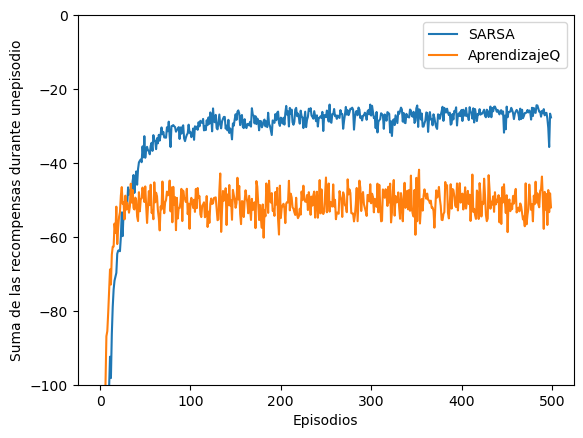

Politica Optima de Sarsa:
['→', '→', '→', '→', '→', '→', '→', '→', '→', '→', '↓', '↓']
['↑', '↑', '→', '↑', '→', '→', '↑', '↑', '↑', '↑', '→', '↓']
['→', '↑', '↑', '→', '↑', '→', '↑', '↑', '→', '←', '→', '↓']
['↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', 'M']
Politica Optima de aprendizaje Q:
['↑', '→', '↑', '↓', '↓', '↓', '↓', '↓', '↓', '↓', '↑', '↓']
['↓', '↓', '↓', '↓', '↓', '↓', '↓', '↓', '↓', '↓', '↓', '↓']
['→', '→', '→', '→', '→', '→', '→', '→', '→', '→', '→', '↓']
['↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', 'M']
CPU times: user 9min 55s, sys: 3.87 s, total: 9min 59s
Wall time: 9min 57s


In [18]:
%%time
curvas_politicas()